<a href="https://colab.research.google.com/github/mohsenMahmoodzadeh/Image-Caption-classification-with-tensorflow-Keras/blob/master/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with Keras

In this notebook, we build a keras model to classify a text dataset with 2658 train and 2658 test senetences. 

We use Tensorflow and Keras for implementation of our model. 

We also use scikit-learn library for some ancillary affairs such as confusion matrix, accuracy score, classification report, etc.

In [77]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import os
import cv2
from matplotlib import pyplot as plt
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.model_selection import KFold, train_test_split
import warnings
warnings.filterwarnings('ignore','FutureWarning')

In [78]:
label_map = {
    0 : 'aeroplane', 1 : 'bicycle', 2 : 'bird', 3 : 'boat', 
    4 : 'bus', 5 : 'car', 6 : 'cat', 7 : 'chair', 8 : 'cow',
    9 : 'diningtable', 10 : 'dog', 11 : 'horse', 12 : 'motorbike',
    13 : 'person', 14 : 'pottedplant', 15 : 'sheep', 16 : 'sofa',
    17 : 'train', 18 : 'tvmonitor'
  }

In [79]:
CATEGORIES = list(label_map.values())

In [80]:
def read_file(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    return lines

In [81]:
def prepare_train_data(TRAIN_DATA_DIR, CATEGORIES):
    train_data = []
    path = ""
    for category in CATEGORIES:
        temp = []
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            try:
                lines = read_file(file_path)
                for line in lines:
                    temp.append(line)

            except Exception as e:
                print(str(e))
        
        for line in temp:
            train_data.append((line, class_num))
    
    return train_data

In [82]:
def prepare_test_data(TEST_DATA_DIR, CATEGORIES):
    test_data = []
    path = ""
    for category in CATEGORIES:
        temp = []
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            file = file_path
            try:
                lines = read_file(file)
                for line in lines:
                    temp.append(line)

            except Exception as e:
                print(str(e))
        
        for line in temp:
            test_data.append((line, class_num))
    return test_data

In [83]:
TRAIN_DATA_DIR = "./dataset/train/sentences/"
TEST_DATA_DIR = "./dataset/test/sentences/"
CATEGORIES = ["aeroplane", "bicycle", "bird", "boat", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", 
              "motorbike", "person", "pottedplant", "sheep","sofa", "train", "tvmonitor"]

In [84]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TRAIN_DATA_DIR,
    label_mode="categorical",
    validation_split=0.2,
    subset='training',
    seed= 1337 
)

Found 532 files belonging to 19 classes.
Using 426 files for training.


In [85]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TRAIN_DATA_DIR,
    label_mode="categorical",
    validation_split=0.2,
    subset='validation',
    seed= 1337 
)

Found 532 files belonging to 19 classes.
Using 106 files for validation.


In [86]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TEST_DATA_DIR,
    label_mode="categorical"
)

Found 380 files belonging to 19 classes.


In [87]:
max_features = None
embedding_dim = 128
sequence_length = 256

In [88]:
vectorization_layer = \
        tf.keras.layers.experimental.preprocessing.TextVectorization(
            output_mode = "int",
            output_sequence_length = sequence_length,
        )

In [89]:
text_ds = raw_train_ds.map(lambda x, y: x)
vectorization_layer.adapt(text_ds)

In [90]:
max_features = vectorization_layer.vocabulary_size()

In [91]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorization_layer(text), label

In [92]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [93]:
def create_model(max_features, embedding_dim):
    
    num_classes = 19
    
    model = tf.keras.models.Sequential()
    
    inputs = tf.keras.Input(shape=(None,), dtype="int64")
    x = tf.keras.layers.Embedding(max_features, embedding_dim)(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv1D(128, 9, padding="valid", activation="relu", strides=3)(x)
    x = tf.keras.layers.Conv1D(128, 9, padding="valid", activation="relu", strides=3)(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax", name="predictions")(x)
    
    model = tf.keras.Model(inputs, predictions)
    return model

In [94]:
model = create_model(max_features, embedding_dim)

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [95]:
epochs = 30
history = model.fit(train_ds,
                    epochs = epochs,
                    validation_data = val_ds
                )

Epoch 1/30
14/14 [==============================] - 8s 329ms/step - loss: 2.9512 - accuracy: 0.0634 - val_loss: 2.9519 - val_accuracy: 0.0377
Epoch 2/30
14/14 [==============================] - 4s 290ms/step - loss: 2.9480 - accuracy: 0.0305 - val_loss: 2.9491 - val_accuracy: 0.0189
Epoch 3/30
14/14 [==============================] - 4s 296ms/step - loss: 2.9447 - accuracy: 0.0399 - val_loss: 2.9487 - val_accuracy: 0.0377
Epoch 4/30
14/14 [==============================] - 5s 299ms/step - loss: 2.9278 - accuracy: 0.0681 - val_loss: 2.9556 - val_accuracy: 0.0472
Epoch 5/30
14/14 [==============================] - 5s 298ms/step - loss: 2.9058 - accuracy: 0.0751 - val_loss: 2.9504 - val_accuracy: 0.0377
Epoch 6/30
14/14 [==============================] - 5s 299ms/step - loss: 2.8664 - accuracy: 0.0892 - val_loss: 2.9273 - val_accuracy: 0.0849
Epoch 7/30
14/14 [==============================] - 5s 294ms/step - loss: 2.7423 - accuracy: 0.1526 - val_loss: 2.8070 - val_accuracy: 0.1415
Epoch 

In [96]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label = "training")
    plt.plot(epochs, val_acc, label = "validation")
    plt.legend(loc="upper left")
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, label = "training")
    plt.plot(epochs, val_loss, label = "validation")
    plt.legend(loc="upper right")
    plt.title('Training and validation loss')

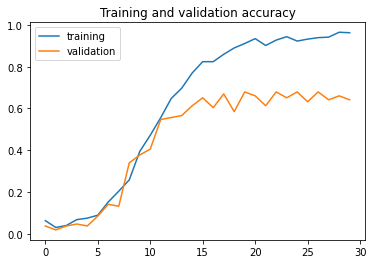

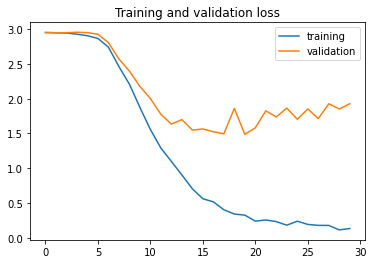

In [97]:
plot_history(history)

In [103]:
# TODO: Earn Confusion Matrix and Classification Report for the model

In [98]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Testing Loss: {:.4f}".format(test_loss))
print("Testing Accuracy:  {:.4f}".format(test_accuracy))

12/12 [==============================] - 2s 75ms/step - loss: 1.8077 - accuracy: 0.6789
Testing Loss: 1.8077
Testing Accuracy:  0.6789


In [ ]:
# TODO: K-fold Cross Validation!

## Resources

1. https://realpython.com/python-keras-text-classification/
2. https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory
3. https://nlp.stanford.edu/projects/glove/
4. https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
5. https://stackoverflow.com/questions/45117295/what-is-the-relation-between-validation-data-and-validation-split-in-keras-fit
6. https://towardsdatascience.com/addressing-the-difference-between-keras-validation-split-and-sklearn-s-train-test-split-a3fb803b733
7. https://towardsdatascience.com/data-augmentation-library-for-text-9661736b13ff
8. https://github.com/makcedward/nlpaug
9. https://www.depends-on-the-definition.com/guide-to-word-vectors-with-gensim-and-keras/
10. https://code.google.com/archive/p/word2vec/
11. https://www.tensorflow.org/api_docs/python/tf/data/Dataset
12. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
13. https://keras.io/examples/nlp/text_classification_from_scratch/
14. https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization